# 1. Import libs

We'll build a 5 layers Sequential Convolutional Neural Network for digits recognition trained on our MNIST dataset.

In [1]:
!pip3 install tensorflow==2.7.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
%matplotlib inline

random_seed = 42
np.random.seed(random_seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

2022-02-17 21:10:44.017793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 21:10:44.017813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Data preparation
## 2.1 Load data

In [2]:
filename = 'mini_mnist.csv'

In [3]:
def bar_custom(current, total, width=100):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

#Don't think too much about the getDataset method. It is used for convenience
def getDataset(filename, **kwargs):
    url = f'https://github.com/IvanReznikov/mdx-msc-data-science/raw/main/datasets/{filename}'
    try:
        import os
        if filename not in os.listdir():
            !pip3 install wget
            import wget
            downloaded_filename = wget.download(url)
            print(f'{downloaded_filename} file downloaded', bar=bar_custom)
        else:
            print(f'{filename} already exists')
        return pd.read_csv(filename, **kwargs)
        
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

In [4]:
data = getDataset(filename, index_col = [0])
data.head(5)

mini_mnist.csv already exists


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

<AxesSubplot:>

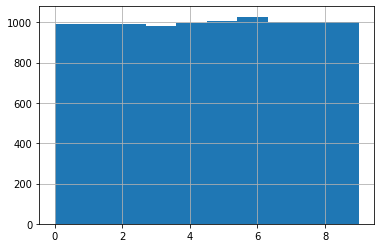

In [6]:
y_train.hist()

We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [7]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. Another reason is that the CNN converg faster on [0..1] data than on [0..255].

In [13]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

## 2.4 Reshape

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

## 2.5 Label encoding

In [18]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]; ex: 5 -> [0,0,0,0,0,1,0,0,0,0].

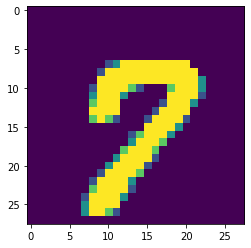

In [19]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 Define the model

We'll continue using Keras Sequential API.
The first is the convolutional (Conv2D) layer. 
We'll set 32 filters for the two first conv2D layers and 64 filters for the last ones. 
Each kernel filter transforms a part of the image (defined by the kernel size). The kernel filter matrix is applied to the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer acts as a downsampling filter. It looks at the 2 (pooling size) neighboring pixels and picks the maximal value. These are used to reduce computational costs and reduce overfitting to some extent. We have to choose the pooling size (i.e, the area pooled each time) more the pooling dimension is high, the more the downsampling is essential. 

Combining convolutional and pooling layers, CNN can combine local features and learn more global characteristics of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This drops a proportion of the network randomly and forces the network to learn features in a distributed way. This technique also improves generalization and reduces overfitting. 

'ReLU' is the rectifier (activation function max(0,x). The rectifier activation function is used to add nonlinearity to the network. 

The Flatten layer is used to convert the final feature maps into a single 1D vector. This flattening step is needed to make use of fully connected layers after some convolutional/max_pool layers. It combines all the found local features of the previous convolutional layers.

In the end, we'll use the features in two fully connected (Dense) layers which is just an artificial neural networks (ANN) classifier. In the last layer(`Dense(10,activation="softmax"`)) the net outputs distribution of probability of each class.

In [20]:
# Set the CNN model 

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

2022-02-17 21:19:01.178471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 21:19:01.178525: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 21:19:01.178556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-ThinkPad-T590): /proc/driver/nvidia/version does not exist
2022-02-17 21:19:01.178853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


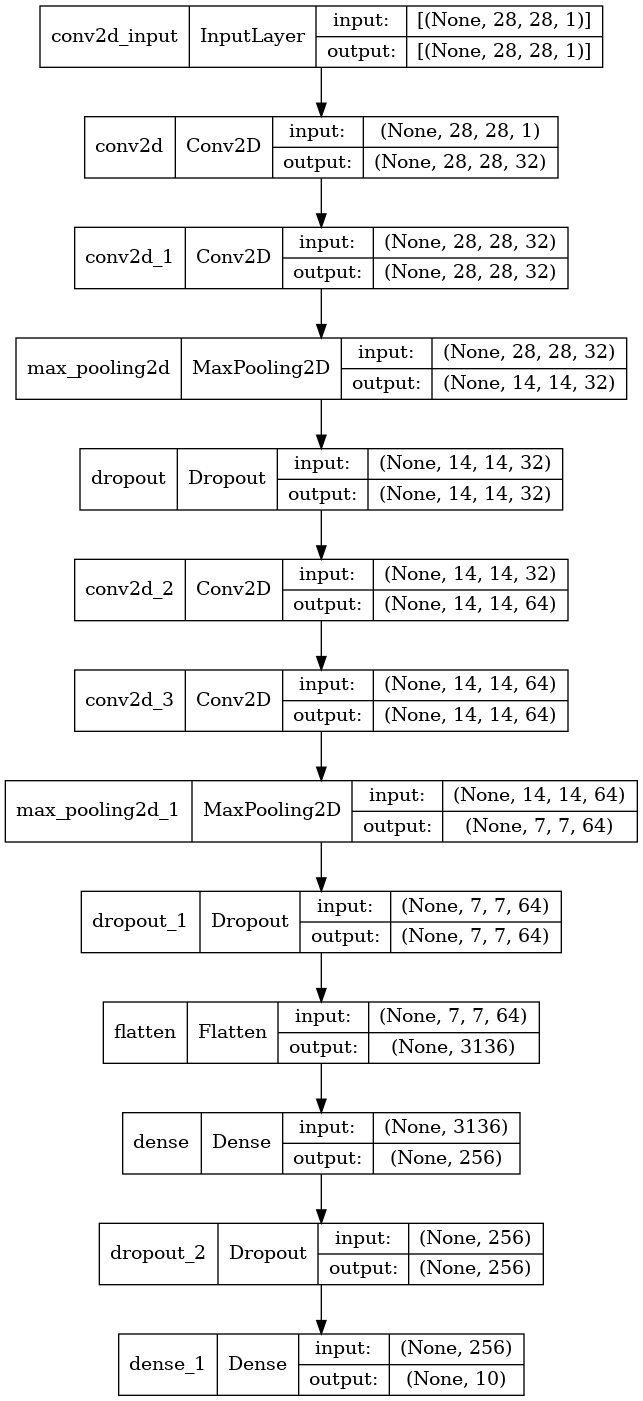

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

## 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function, and an optimization algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the observed labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy."

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights, and bias of neurons) to minimize the loss. 

We'll go with RMSprop (with default values), which is a very effective optimizer. The RMSProp update the Adagrad method to reduce its aggressive, monotonically decreasing learning rate.
We can consider using Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used to evaluate our model's performance.
This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [23]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/home/ivan/.local/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

To make the optimizer converge faster and closest to the global minimum of the loss function, we'll use an annealing method of the learning rate (LR).

The LR is the optimizer's walk through the 'loss landscape.' The higher LR, the bigger are the steps and the quicker the convergence is. However, the sampling is inferior with a high LR, and the optimizer could probably fall into a local minimum.

It's better to have a decreasing learning rate during the training to reach the loss function's global minimum efficiently. 

To keep the advantage of the fast computation time with a high LR, we dynamically decreased the LR every K steps (epochs) depending on whether it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, we'll reduce the LR by half if the accuracy is not improved after 3 epochs.

In [25]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 75

## 3.3 Data augmentation 

To avoid the overfitting problem, we need to artificially expand our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occurring when someone writes a digit.

For example, the number is not centered. 
The scale is not the same (some who write with big/small numbers)
The image is rotated, etc.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

We can easily double or triple the number of training examples and create a very robust model by applying just a couple of these transformations to our training data.

In [28]:
# Without data augmentation
'''
history_no_augmentation = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_test, y_test), verbose = 2)
'''

'\nhistory_no_augmentation = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, \n          validation_data = (X_test, y_test), verbose = 2)\n'

In [29]:
# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

For the data augmentation, we'll do the following :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
We didn't apply a vertical_flip or horizontal_flip since it could have misclassified symmetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset.

In [30]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/tmp/ipykernel_56335/2645601918.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/5
133/133 - 31s - loss: 0.8805 - accuracy: 0.7135 - val_loss: 0.1351 - val_accuracy: 0.9576 - lr: 0.0010 - 31s/epoch - 236ms/step
Epoch 2/5
133/133 - 34s - loss: 0.3053 - accuracy: 0.9029 - val_loss: 0.0708 - val_accuracy: 0.9780 - lr: 0.0010 - 34s/epoch - 254ms/step
Epoch 3/5
133/133 - 33s - loss: 0.2073 - accuracy: 0.9395 - val_loss: 0.1059 - val_accuracy: 0.9692 - lr: 0.0010 - 33s/epoch - 249ms/step
Epoch 4/5
133/133 - 33s - loss: 0.1640 - accuracy: 0.9490 - val_loss: 0.0543 - val_accuracy: 0.9804 - lr: 0.0010 - 33s/epoch - 249ms/step
Epoch 5/5
133/133 - 33s - loss: 0.1379 - accuracy: 0.9591 - val_loss: 0.0501 - val_accuracy: 0.9848 - lr: 0.0010 - 33s/epoch - 248ms/step


# 4. Evaluate the model
## 4.1 Training and validation curves

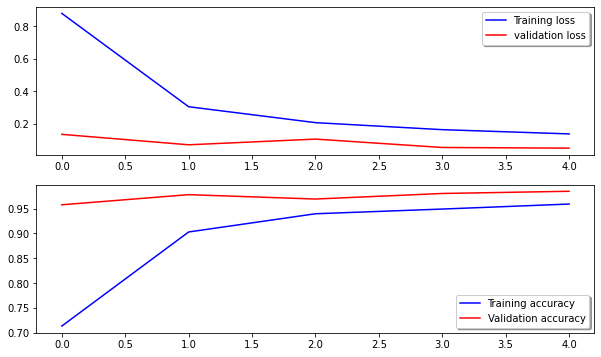

In [31]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The model reaches about 96% accuracy on the validation dataset after 5 epochs. The validation accuracy is greater than the training accuracy in almost every training. That means that our model doesn't overfit the training set.

We can compare the accuracy with a regular neural network implemented a couple of weeks earlier (91%)

## 4.2 Confusion matrix

In [32]:

# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_predicted_labels = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1) 
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[258,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 256,   0,   1,   0,   0,   0,   0,   0,   0],
       [  2,   2, 249,   1,   0,   0,   0,   1,   3,   0],
       [  0,   0,   0, 268,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 246,   0,   1,   0,   0,   4],
       [  0,   0,   0,   1,   0, 238,   0,   0,   2,   0],
       [  0,   0,   0,   0,   1,   1, 218,   0,   2,   0],
       [  0,   0,   1,   2,   3,   0,   0, 240,   0,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0, 247,   0],
       [  1,   0,   0,   0,   1,   0,   0,   2,   1, 242]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

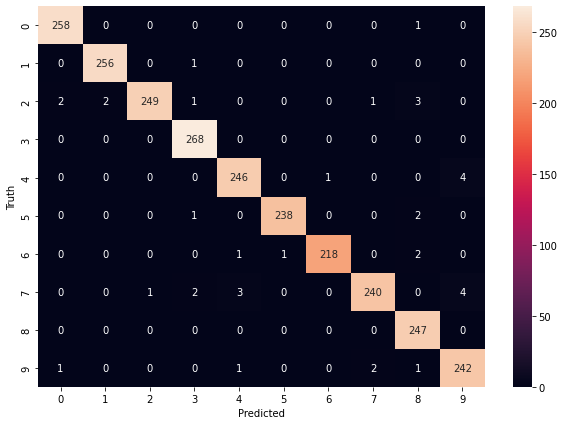

In [33]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Here we can see that our CNN performs very well on all digits with few errors considering the size of the test set. However, it seems that our CNN has some minor troubles with the 2 numbers predicted as 7, 4 digits misclassified as 9, and 9 digits considered as 7.
Let's investigate for errors. We'll need to get the difference between the probabilities of real value and the predicted ones in the results.

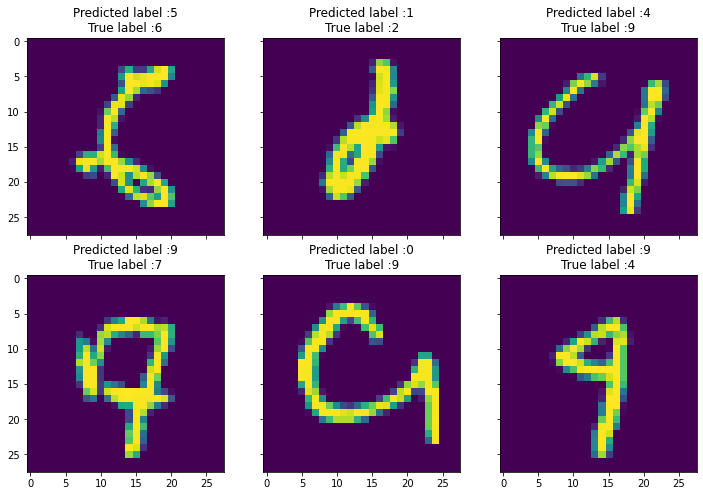

In [34]:
# Errors are difference between predicted labels and true labels
errors = (y_predicted_labels - y_true != 0)

Y_pred_classes_errors = y_predicted_labels[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,8))
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Yep, we can see that the model makes mistakes, that we can explain. We still can increase the result by tweaking the pipeline